Tarea 1: memoria de cálculo

In [379]:
# Importar librerías necesarias

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
from matplotlib.patches import Polygon
from scipy.spatial import KDTree

In [380]:
# Funciones matemáticas útiles


def sen(x):
    return np.sin(np.deg2rad(x))

def cos(x):
    return np.cos(np.deg2rad(x))

def tan(x):
    return np.tan(np.deg2rad(x))

def arcos(x):
    return np.rad2deg(np.arccos(x))

def adsin(x):
    return np.rad2deg(np.arcsin(x))

def adtan(x):
    return np.rad2deg(np.arctan(x))


# Funciones útiles para geometría solar

def declinacion(dia):
    return 23.45*sen(360*(284+dia)/366)

def ecuacion_del_tiempo(dia):
    b = (dia-1)*360/365
    E = 229.2*10**(-5)*(7.5+186*cos(b)-3200.7*sen(b)-1461.5*cos(2*b)-4089*sen(2*b))
    return E

def long_std(utc):
    return (utc)*15

def t_solar(t_local, long_loc, long_std, dia):
    return t_local*60+4*(long_loc-long_std)+ecuacion_del_tiempo(dia)

def ang_horario(t):
    return -180+t*15/60

def cenit_solar(lat, dec, w):
    return np.rad2deg(np.arccos(cos(lat)*cos(dec)*cos(w)+sen(lat)*sen(dec)))

def azimut_solar(w, cen, dec, lat):
    return np.rad2deg(np.sign(w)*np.abs(np.arccos((cos(cen)*sen(lat)-sen(dec))/(sen(cen)*cos(lat)))))+180

def incidencia(cenit, beta, azimut, acip):
    return np.rad2deg(np.arccos(cos(cenit)*cos(beta)+sen(cenit)*sen(beta)*cos(azimut-acip)))

# Pregunta 2


Santiago de Chile

In [ ]:
# Solsticio de verano

# En Santiago de Chile el solsticio de verano es el 21 de diciembre.

# Tomamos las latitudes y longitudes de Santiago:

longstgo = -70
latstgo = -33.5
utc = -4

# Tomamos el día pedido:

solsticio_verano = pd.date_range(start='21/12/2025', end='22/12/2025', freq='1min')


def angulo_horario(elevacion_solar, latitud, declinacion):
    w=arcos((sen(elevacion_solar)-sen(latitud)*sen(declinacion))/(cos(latitud)*cos(declinacion)))
    return(w)

# Datos

h_cordillera = 3600 # m

d_santiago = 35000 # m
d_casablanca = 100000 # m
d_valparaiso = 140000 # m

declin = declinacion(solsticio_verano.day_of_year[0])

# Elevación solar en la punta de la cordillera para cada ciudad

alpha_santiago = adtan(h_cordillera / d_santiago)
alpha_casablanca = adtan(h_cordillera / d_casablanca)
alpha_valparaiso = adtan(h_cordillera / d_valparaiso)


In [382]:
elevacion_verano = []
azimut_verano = []
indicencia_verano = []
cenit_verano = [] # listas vacías para guardar los datos

horas = [] # lista vacía para graficar después

i = 0

while i <= 24:
    i = i + 0.2
    horas.append(i)

for hora in solsticio_verano:
    declin = declinacion(solsticio_verano.day_of_year[0])
    tsolar = t_solar(hora.hour + hora.minute/60, longstgo, long_std(-4), solsticio_verano.day_of_year[0])
    w = ang_horario(tsolar)
    cenit = cenit_solar(latstgo, declin, w)
    azimut = azimut_solar(w, cenit, declin, latstgo)
    incid = incidencia(cenit, 0, azimut, 0)
    
    elevacion_verano.append(90-cenit)
    azimut_verano.append(azimut)
    indicencia_verano.append(incid)
    cenit_verano.append(cenit)

for i in elevacion_verano:
    if i < 0:
        elevacion_verano[elevacion_verano.index(i)] = 0 # reemplazar los negativos por 0

for i in cenit_verano:
    if i > 90:
        cenit_verano[cenit_verano.index(i)] = 90 # reemplazar los mayores a 90 por 90

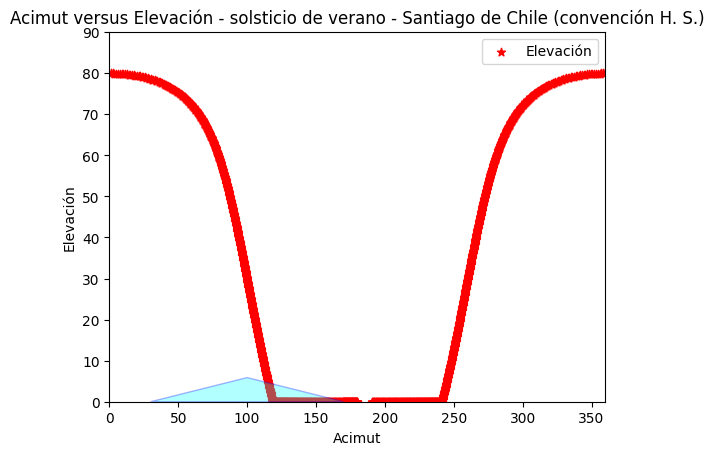

In [383]:
# Gráfico de Azimut - Elevación Solar - Convención H.S.


# Cordillera triangular
triangle_coords = [(30, 0), (170, 0), (100, alpha_santiago)]
triangle = Polygon(triangle_coords, closed=True, fill=True, edgecolor='blue', facecolor='cyan', alpha=0.3)

# Gráfico

plt.figure()
plt.scatter(azimut_verano, elevacion_verano, label='Elevación', c='red', marker='*')
plt.gca().add_patch(triangle)
plt.xlabel('Acimut')
plt.ylabel('Elevación')
plt.title('Acimut versus Elevación - solsticio de verano - Santiago de Chile (convención H. S.)')
plt.legend(loc = 'upper right')
plt.xlim([0, 360])
plt.ylim([0, 90])
plt.show()

Zoom a la zona de interés

[[30.          0.        ]
 [31.00719424  0.08449825]
 [32.01438849  0.1689965 ]
 [33.02158273  0.25349475]
 [34.02877698  0.33799299]]


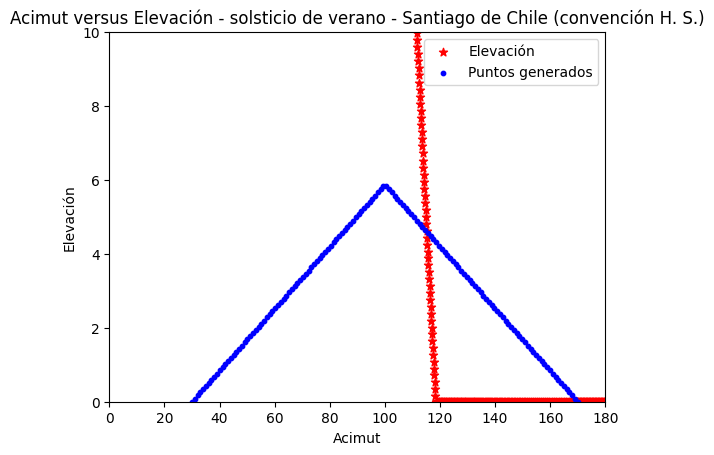

In [ ]:
# Cordillera triangular - generación de puntos
A = (30, 0)
B = (100, alpha_santiago)
C = (170, 0)

# 140 puntos en x (30 a 170)
x_values = np.linspace(A[0], C[0], 140)

# Pendientes
m_AB = (B[1] - A[1]) / (B[0] - A[0])  # pendiente de AB
m_BC = (C[1] - B[1]) / (C[0] - B[0])  # pendiente de BC

# Calcular y según si x está en la primera o segunda mitad
y_values = np.where(
    x_values <= B[0],
    A[1] + m_AB * (x_values - A[0]),
    B[1] + m_BC * (x_values - B[0])
)

points = np.column_stack((x_values, y_values))


# Gráfico

plt.figure()
plt.scatter(azimut_verano, elevacion_verano, label='Elevación', c='red', marker='*')
plt.scatter(points[:,0], points[:,1], color='blue', s=10, label='Puntos generados')
plt.xlabel('Acimut')
plt.ylabel('Elevación')
plt.title('Acimut versus Elevación - solsticio de verano - Santiago de Chile (convención H. S.)')
plt.legend(loc = 'upper right')
plt.xlim([0, 180])
plt.ylim([0, 10])
plt.show()

## Punto de intersección aproximado
Se busca el punto aproximado de la intersección de la cordillera con la curva Acimut vs Elevación

In [385]:
# Puntos del triángulo
points = np.column_stack((x_values, y_values))  # shape (N, 2)

# Puntos de la curva solar (listas)
azimut_verano = np.array(azimut_verano)
elevacion_verano = np.array(elevacion_verano)
curve = np.column_stack((azimut_verano, elevacion_verano))  # shape (M, 2)


# --- FILTRAR LA CURVA POR RANGO DE ACIMUT ---
mask = (curve[:, 0] >= 110) & (curve[:, 0] <= 130)
curve_filtered = curve[mask]

# --- USAR KDTree SOLO CON LOS PUNTOS FILTRADOS ---
tree = KDTree(curve_filtered)
distances, indices = tree.query(points)
idx_min = np.argmin(distances)

closest_triangle_point = points[idx_min]
closest_curve_point_stgo = curve_filtered[indices[idx_min]]
min_dist = distances[idx_min]

print(f"Punto triángulo más cercano: {closest_triangle_point}")
print(f"Punto curva más cercano (en [110,130]): {closest_curve_point_stgo}")
print(f"Distancia mínima: {min_dist}")


Punto triángulo más cercano: [115.61151079   4.56290543]
Punto curva más cercano (en [110,130]): [115.28408074   4.44071942]
Distancia mínima: 0.34948513718127033


Lo mismo en Casablanca y Valparaíso

[[3.00000000e+01 0.00000000e+00]
 [3.10071942e+01 2.96655783e-02]
 [3.20143885e+01 5.93311566e-02]
 [3.30215827e+01 8.89967349e-02]
 [3.40287770e+01 1.18662313e-01]]


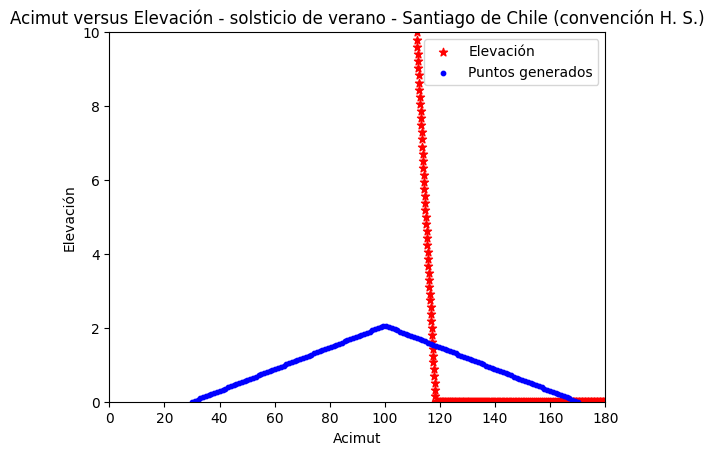

Punto triángulo más cercano: [117.62589928   1.54261007]
Punto curva más cercano (en [110,130]): [117.37160926   1.43586041]
Distancia mínima: 0.2757877851991411


In [ ]:
# Casablanca

long_casablanca = -71.4100762
lat_casablanca = -33.3205864
utc = -4




elevacion_verano = []
azimut_verano = []
indicencia_verano = []
cenit_verano = [] # listas vacías para guardar los datos

horas = [] # lista vacía para graficar después

i = 0

while i <= 24:
    i = i + 0.2
    horas.append(i)

for hora in solsticio_verano:
    declin = declinacion(solsticio_verano.day_of_year[0])
    tsolar = t_solar(hora.hour + hora.minute/60, long_casablanca, long_std(-4), solsticio_verano.day_of_year[0])
    w = ang_horario(tsolar)
    cenit = cenit_solar(lat_casablanca, declin, w)
    azimut = azimut_solar(w, cenit, declin, lat_casablanca)
    incid = incidencia(cenit, 0, azimut, 0)
    
    elevacion_verano.append(90-cenit)
    azimut_verano.append(azimut)
    indicencia_verano.append(incid)
    cenit_verano.append(cenit)

for i in elevacion_verano:
    if i < 0:
        elevacion_verano[elevacion_verano.index(i)] = 0 # reemplazar los negativos por 0

for i in cenit_verano:
    if i > 90:
        cenit_verano[cenit_verano.index(i)] = 90 # reemplazar los mayores a 90 por 90



# Cordillera triangular - generación de puntos
A = (30, 0)
B = (100, alpha_casablanca)
C = (170, 0)

# 140 puntos en x (30 a 170)
x_values = np.linspace(A[0], C[0], 140)

# Pendientes
m_AB = (B[1] - A[1]) / (B[0] - A[0])  # pendiente de AB
m_BC = (C[1] - B[1]) / (C[0] - B[0])  # pendiente de BC

# Calcular y según si x está en la primera o segunda mitad
y_values = np.where(
    x_values <= B[0],
    A[1] + m_AB * (x_values - A[0]),
    B[1] + m_BC * (x_values - B[0])
)

points = np.column_stack((x_values, y_values))


# Gráfico

plt.figure()
plt.scatter(azimut_verano, elevacion_verano, label='Elevación', c='red', marker='*')
plt.scatter(points[:,0], points[:,1], color='blue', s=10, label='Puntos generados')
plt.xlabel('Acimut')
plt.ylabel('Elevación')
plt.title('Acimut versus Elevación - solsticio de verano - Santiago de Chile (convención H. S.)')
plt.legend(loc = 'upper right')
plt.xlim([0, 180])
plt.ylim([0, 10])
plt.show()




# Puntos del triángulo
points = np.column_stack((x_values, y_values))  # shape (N, 2)

# Puntos de la curva solar (listas)
azimut_verano = np.array(azimut_verano)
elevacion_verano = np.array(elevacion_verano)
curve = np.column_stack((azimut_verano, elevacion_verano))  # shape (M, 2)


# --- FILTRAR LA CURVA POR RANGO DE ACIMUT ---
mask = (curve[:, 0] >= 110) & (curve[:, 0] <= 130)
curve_filtered = curve[mask]

# --- USAR KDTree SOLO CON LOS PUNTOS FILTRADOS ---
tree = KDTree(curve_filtered)
distances, indices = tree.query(points)
idx_min = np.argmin(distances)

closest_triangle_point = points[idx_min]
closest_curve_point_casablanca = curve_filtered[indices[idx_min]]
min_dist = distances[idx_min]

print(f"Punto triángulo más cercano: {closest_triangle_point}")
print(f"Punto curva más cercano (en [110,130]): {closest_curve_point_casablanca}")
print(f"Distancia mínima: {min_dist}")

valpo

[[3.00000000e+01 0.00000000e+00]
 [3.10071942e+01 2.11941790e-02]
 [3.20143885e+01 4.23883580e-02]
 [3.30215827e+01 6.35825370e-02]
 [3.40287770e+01 8.47767161e-02]]


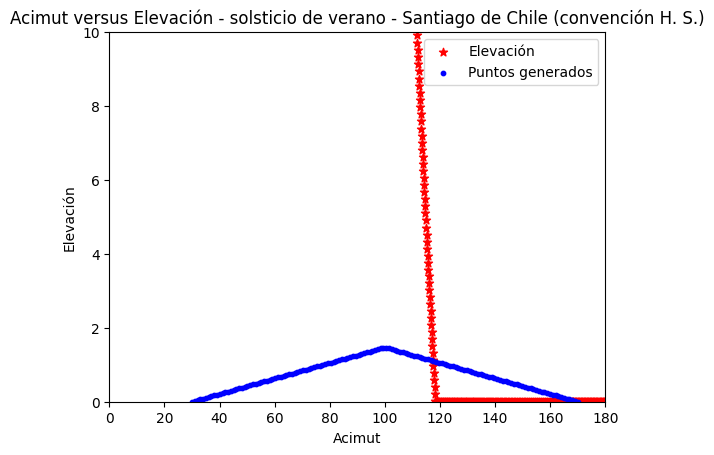

Punto triángulo más cercano: [117.62589928   1.10209731]
Punto curva más cercano (en [110,130]): [117.49553741   1.14164996]
Distancia mínima: 0.1362300616165889


In [ ]:
# valpo

long_valparaiso = -71.62963
lat_valparaiso = -33.036
utc = -4


elevacion_verano = []
azimut_verano = []
indicencia_verano = []
cenit_verano = [] # listas vacías para guardar los datos

horas = [] # lista vacía para graficar después

i = 0

while i <= 24:
    i = i + 0.2
    horas.append(i)

for hora in solsticio_verano:
    declin = declinacion(solsticio_verano.day_of_year[0])
    tsolar = t_solar(hora.hour + hora.minute/60, long_valparaiso, long_std(-4), solsticio_verano.day_of_year[0])
    w = ang_horario(tsolar)
    cenit = cenit_solar(lat_valparaiso, declin, w)
    azimut = azimut_solar(w, cenit, declin, lat_valparaiso)
    incid = incidencia(cenit, 0, azimut, 0)
    
    elevacion_verano.append(90-cenit)
    azimut_verano.append(azimut)
    indicencia_verano.append(incid)
    cenit_verano.append(cenit)

for i in elevacion_verano:
    if i < 0:
        elevacion_verano[elevacion_verano.index(i)] = 0 # reemplazar los negativos por 0

for i in cenit_verano:
    if i > 90:
        cenit_verano[cenit_verano.index(i)] = 90 # reemplazar los mayores a 90 por 90



# Cordillera triangular - generación de puntos
A = (30, 0)
B = (100, alpha_valparaiso)
C = (170, 0)

# 140 puntos en x (30 a 170)
x_values = np.linspace(A[0], C[0], 140)

# Pendientes
m_AB = (B[1] - A[1]) / (B[0] - A[0])  # pendiente de AB
m_BC = (C[1] - B[1]) / (C[0] - B[0])  # pendiente de BC

# Calcular y según si x está en la primera o segunda mitad
y_values = np.where(
    x_values <= B[0],
    A[1] + m_AB * (x_values - A[0]),
    B[1] + m_BC * (x_values - B[0])
)

points = np.column_stack((x_values, y_values))


# Gráfico

plt.figure()
plt.scatter(azimut_verano, elevacion_verano, label='Elevación', c='red', marker='*')
plt.scatter(points[:,0], points[:,1], color='blue', s=10, label='Puntos generados')
plt.xlabel('Acimut')
plt.ylabel('Elevación')
plt.title('Acimut versus Elevación - solsticio de verano - Santiago de Chile (convención H. S.)')
plt.legend(loc = 'upper right')
plt.xlim([0, 180])
plt.ylim([0, 10])
plt.show()




# Puntos del triángulo
points = np.column_stack((x_values, y_values))  # shape (N, 2)

# Puntos de la curva solar (listas)
azimut_verano = np.array(azimut_verano)
elevacion_verano = np.array(elevacion_verano)
curve = np.column_stack((azimut_verano, elevacion_verano))  # shape (M, 2)


# --- FILTRAR LA CURVA POR RANGO DE ACIMUT ---
mask = (curve[:, 0] >= 110) & (curve[:, 0] <= 130)
curve_filtered = curve[mask]

# --- USAR KDTree SOLO CON LOS PUNTOS FILTRADOS ---
tree = KDTree(curve_filtered)
distances, indices = tree.query(points)
idx_min = np.argmin(distances)

closest_triangle_point = points[idx_min]
closest_curve_point_valpo = curve_filtered[indices[idx_min]]
min_dist = distances[idx_min]

print(f"Punto triángulo más cercano: {closest_triangle_point}")
print(f"Punto curva más cercano (en [110,130]): {closest_curve_point_valpo}")
print(f"Distancia mínima: {min_dist}")

In [388]:
# Ángulo horario para cada ciudad

angulo_horario_santiago = angulo_horario(closest_curve_point_stgo[1], latstgo, declin)
angulo_horario_casablanca = angulo_horario(closest_curve_point_casablanca[1], lat_casablanca, declin)
angulo_horario_valparaiso = angulo_horario(closest_curve_point_valpo[1], lat_valparaiso, declin)

# Ángulo horario del amanecer

angulo_horario_amanecer_santiago = angulo_horario(0, latstgo, declin)
angulo_horario_amanecer_casablanca = angulo_horario(0, lat_casablanca, declin)
angulo_horario_amanecer_valparaiso = angulo_horario(0, lat_valparaiso, declin)

# Tiempo de obstrucción

tiempo_obstruccion_santiago = (angulo_horario_amanecer_santiago - angulo_horario_santiago) / 15 * 60 # minutos
tiempo_obstruccion_casablanca = (angulo_horario_amanecer_casablanca - angulo_horario_casablanca) / 15 * 60 # minutos
tiempo_obstruccion_valparaiso = (angulo_horario_amanecer_valparaiso - angulo_horario_valparaiso) / 15 * 60 # minutos

print(f"Tiempo de obstrucción en Santiago: {tiempo_obstruccion_santiago:.2f} minutos")
print(f"Tiempo de obstrucción en Casablanca: {tiempo_obstruccion_casablanca:.2f} minutos")
print(f"Tiempo de obstrucción en Valparaíso: {tiempo_obstruccion_valparaiso:.2f} minutos")

Tiempo de obstrucción en Santiago: 23.88 minutos
Tiempo de obstrucción en Casablanca: 7.78 minutos
Tiempo de obstrucción en Valparaíso: 6.16 minutos
